In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip3 install dwave-system
!pip install pandas-datareader --upgrade
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.5/103.5 KB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 57.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 74.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 63.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 82.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.4/111.4 KB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 61.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.4/102.4 KB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 KB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 KB 22.4 MB/s eta 0:00:00
  Attempting uninstall: networkx
    Found existing installation: networkx 3.0
    Uninstalling ne

In [3]:
from ast import Return
from itertools import product
import json
import random
import numpy as np
import pandas as pd
import os
import sys
import time
import yaml
#from pandas_datareader.data import DataReader
import datetime as dt
from dimod import Integer, Binary
from dimod import quicksum
from dimod import ConstrainedQuadraticModel, DiscreteQuadraticModel
from dwave.system import LeapHybridDQMSampler, LeapHybridCQMSampler
from dimod import ExactSolver, ExactCQMSolver
import gc
import matplotlib
import seaborn as sns
from itertools import takewhile, count
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_model import ARMAResults 
from IPython.display import clear_output
from typing import NamedTuple
import yfinance as yf
from pandas_datareader import data as pdr
yf.pdr_override()


try:
    import matplotlib.pyplot as plt
except ImportError:
    matplotlib.use("agg")
    import matplotlib.pyplot as plt

pd.set_option('max_row', None)
pd.set_option('max_column', None)


class SinglePeriod:
    def __init__(
        self, 
        data,  
        preds, 
        budget, 
        init_budget,
        share_budget,
        sampler, 
        sampler_args,
        dates,
        model_type,
        alpha,
        verbose,
        t_cost,
        label,
        init_holdings):
    
        self.df = data
        self.preds = preds
        self.budget = budget
        self.share_budget = share_budget
        self.init_budget = init_budget
        self.dates = dates
        self.model_type = model_type
        self.verbose = verbose
        self.t_cost = t_cost
        self.label = label
        self.stocks = self.df.columns.tolist()
        
        if init_holdings is not None:
            self.init_holdings = init_holdings
        else:
            self.init_holdings = {s:0 for s in self.stocks}
  
        if isinstance(alpha, (list, tuple)):
            self.alpha = alpha[0]
            self.alpha_list = list(alpha)
        elif isinstance (alpha, (int, float)):
            self.alpha = alpha
        else:
            raise TypeError("Use integer or float for alpha, or a list or tuple of either type.")

        self.model = {'CQM': None, 'DQM': None}

        self.sample_set = {}
        if sampler_args:
            self.sampler_args = json.loads(str(sampler_args))
        else:
            self.sampler_args = {}

        self.sampler = {'CQM': LeapHybridCQMSampler(**self.sampler_args), 'Exact': ExactCQMSolver()}
        #self.sampler = sampler
        self.solution = {}
        self.precision = 2

        self.list_dates = self.df.index.values

    def build_cqm(self, idx, max_risk=None, min_return=None):
        # Instantiating the CQM object
        cqm = ConstrainedQuadraticModel()
        print(f'idx: {idx}')
        #print(f'self.df.loc: {self.df.loc[idx,:]}')
        self.max_num_shares = (self.share_budget/self.df.loc[idx,:]).astype(int)
        #print(f'max_num_shares: {self.max_num_shares}')
        # Defining and adding variables to the CQM model
        x = {s: Integer("%s" %s, lower_bound=0, upper_bound=self.max_num_shares[s]) for s in self.stocks}
        #print(f'x: {x}')
        
        #print(f'self.df')
        #display(self.df.head())
        #print(f'self.df.index.values: {self.df.index.values}')
        #print(f'self.list_dates: {self.list_dates}')
        self.position = np.where(self.list_dates == idx)[0][0]
        print(f'self.position: {self.position}')
        #self.position2 = np.where(self.list_dates == idx)[0]
        #print(f'self.position 2: {self.position2}')
        self.initial_position = self.list_dates[self.position-5]
        print(f'self.initial_position: {self.initial_position}')
        #print('self.df')
        #display(self.df)
        self.price = self.df.loc[idx, :]
        print(f'sum price: {self.price.sum()}')
        #print(f'price: {self.price}')
        #print(self.price)
        self.pct_returns = self.df.pct_change()
        self.daily_returns = self.pct_returns.loc[self.initial_position:idx, :]
        #self.daily_returns = self.pct_returns.loc[self.initial_position:idx, :]
        print(f'sum daily returns: {self.daily_returns.stack().sum()}')
        #self.avg_daily_returns = self.daily_returns.rolling(window=1).mean().loc[idx,:]
        self.avg_daily_returns = self.preds
        print(f'avg daily returns: {self.avg_daily_returns.sum()}')
        # print('avg daily returns 2')
        # display(self.avg_daily_returns2.head())
        self.covariance_matrix = self.daily_returns.cov()
        self.correlation_matrix = self.daily_returns.corr()
        #print('cov matrix')
        #display(self.covariance_matrix.head())
        print(f'covariance_matrix sum: {self.covariance_matrix.stack().sum()}')
        #print('corr matrix')
        #display(self.correlation_matrix.head())
        print(f'correlation_matrix sum: {self.correlation_matrix.stack().sum()}')

        
        # Defining risk expression
        risk = 0
        for s1, s2 in product(self.stocks, self.stocks):
            coeff = (self.covariance_matrix[s1][s2] * self.price[s1] * self.price[s2])
            risk = risk + coeff*x[s1]*x[s2]       
        #print(f'risk: {risk}')

        returns = 0
        for s in self.stocks:
            returns = returns + self.price[s] * self.avg_daily_returns[s] * x[s]
        #print(f'returns: {returns}')

        if not self.t_cost:
            print('t_cost False')
            cqm.add_constraint(quicksum([x[s]*self.price[s] for s in self.stocks]) <= self.budget, label='upper_budget')
            cqm.add_constraint(quicksum([x[s]*self.price[s] for s in self.stocks]) >= 0.997*self.budget, label='lower_budget')
        else:
            print('t_cost True')
            # Modeling transaction cost
            x0 = self.init_holdings
            #print(f'self.init_holdings: {self.init_holdings}')
            # y indicates stock allocations that changed
            y = {s: Binary("Y[%s]" %s) for s in self.stocks}

            lhs = 0

            for s in self.stocks:
                lhs = lhs + 2*self.t_cost*self.price[s]*x[s]*y[s] + self.price[s]*(1 - self.t_cost)*x[s] \
                      - 2*self.t_cost*self.price[s]*x0[s]*y[s] - self.price[s]*(1 - self.t_cost)*x0[s]

            print(f't_cost: {self.t_cost}')
            print(f'upper bound = budget: {self.budget}')
            print(f'init_budget: {self.init_budget}')
            print(f'lower bound: {self.budget - 0.003*self.init_budget}')
            #print(f'lhs: {lhs}')

            cqm.add_constraint(lhs <= self.budget, label='upper_budget')
            cqm.add_constraint(lhs >= self.budget - 0.003*self.init_budget, label='lower_budget')

            # indicator constraints
            for s in self.stocks:
                cqm.add_constraint(x[s] - x0[s]*y[s] >= 0, label=f'indicator_constraint_gte_{s}')
                cqm.add_constraint(x[s] - x[s]*y[s] <= x0[s], label=f'indicator_constraint_lte_{s}')

           
        if max_risk:
            # Adding maximum risk constraint
            cqm.add_constraint(risk <= max_risk, label='max_risk')

            # Objective: maximize return
            cqm.set_objective(-1*returns)
        elif min_return:
            # Adding minimum returns constraint
            cqm.add_constraint(returns >= min_return, label='min_return')

            # Objective: minimize risk
            cqm.set_objective(risk)
        else:
            # Objective: minimize mean-variance expression
            #print('cqm debugging')
            #print(f'risk: {type(risk)}')
            #print(f'returns: {returns}')
            #print(f'objective: {self.alpha*risk - returns}')

            cqm.set_objective(self.alpha*risk - returns)
            #cqm.set_objective(-1*returns)

        cqm.substitute_self_loops()

        self.model['CQM'] = cqm

    def solve_cqm(self, idx, max_risk=None, min_return=None):
        self.build_cqm(idx, max_risk, min_return)

        if self.model_type == 'CQM':
            self.sample_set['CQM'] = self.sampler['CQM'].sample_cqm(self.model['CQM'], label=self.label)
        else:        
            gc.collect()
            self.sample_set['CQM'] = self.sampler['Exact'].sample_cqm(self.model['CQM'])

        n_samples = len(self.sample_set['CQM'].record)
        print(f'n_samples: {n_samples}')
        feasible_samples = self.sample_set['CQM'].filter(lambda d: d.is_feasible)

        if not feasible_samples:
            raise Exception("No feasible solution could be found for this problem instance.")
        else:
            best_feasible = feasible_samples.first

            solution = {}
            solution['stocks'] = {k:int(best_feasible.sample[k]) for k in self.stocks}
            print(f'solution_stocks: {solution["stocks"]}')
            solution['return'], solution['risk'] = self.compute_risk_and_returns(solution['stocks'])
            print(f'solution_return: {solution["return"]}')
            print(f'solution_risk: {solution["risk"]}')
            spending = sum([self.price[s]*max(0, solution['stocks'][s] - self.init_holdings[s]) for s in self.stocks])
            print(f'spending: {spending}')
            sales = sum([self.price[s]*max(0, self.init_holdings[s] - solution['stocks'][s]) for s in self.stocks])
            print(f'sales: {sales}')

            transaction = self.t_cost*(spending + sales)
            print(f'transaction: {transaction}')

            if self.verbose:
                print(f'Number of feasible solutions: {len(feasible_samples)} out of {n_samples} sampled.')
                print(f'\nBest energy: {self.sample_set["CQM"].first.energy: .2f}')
                print(f'Best energy (feasible): {best_feasible.energy: .2f}')

            print(f"\nEstimated Returns: {solution['return']}")
            print(f"Sales Revenue: {sales:.2f}")
            print(f"Purchase Cost: {spending:.2f}")
            print(f"Transaction Cost: {transaction:.2f}")
            print(f"Variance: {solution['risk']}\n")

            #print(f'solution: {solution}')
            return solution


    def compute_risk_and_returns(self, solution):
        """Compute the risk and return values of solution.
        """
        sum_solution = 0
        for s1 in solution:
            #print(f's1: {s1}, {solution[s1]}, price: {self.price[s1]}')
            sum_solution += solution[s1]
            #print(f'covariance matrix: {self.covariance_matrix[s1].sum()}')

        print(f'MMM price: {self.price["MMM"]}, solution: {solution["MMM"]}')
        print(f'sum price: {sum(self.price)}')
        print(f'sum solution: {sum_solution}')

        variance = 0.0
        for s1, s2 in product(solution, solution):
            variance += (solution[s1] * self.price[s1] * solution[s2] * self.price[s2] * self.covariance_matrix[s1][s2])

        est_return = 0
        for stock in solution:
            est_return += solution[stock]*self.price[stock]*self.avg_daily_returns[stock]

        return round(est_return, 2), round(variance, 2)

    def run(self, min_return=0, max_risk=0):

        return self.solve_cqm(min_return=min_return, max_risk=max_risk)

In [4]:
class MultiPeriod():
    """Solve the multi-period (dynamic) portfolio optimization problem.
    """
    def __init__(self, 
                data, 
                baseline,
                budget,
                sampler_args,
                dates,
                file_path,
                model_type,
                alpha,
                verbose,
                t_cost,
                label,
                init_holdings,
                save_path):
    
        self.save_path = save_path
        self.df = data
        self.stocks = self.df.columns.values.tolist()
        self.stocks = sorted(self.stocks)

        
        self.sampler_args = sampler_args
        self.budget = budget
        self.sampler_args = sampler_args
        self.verbose = verbose
        self.label = label
        self.t_cost = t_cost
        self.baseline = baseline
        self.dates = dates
        self.model_type = model_type
        
        initial_gspc = self.baseline.query('Date==@dates[0]').values.tolist()[0][0]
        #print('initial baseline')
        #display(self.baseline)
        #print(f'initial_gspc: {initial_gspc}')
        self.baseline.iloc[:,0] = (self.baseline.iloc[:,0] / initial_gspc - 1)
        self.init_budget = budget
        #print('final baseline')
        #display(self.baseline)
        #print('initial data')
        #display(self.df.head())

        if init_holdings is not None:
            self.init_holdings = init_holdings
        else:
            self.init_holdings = {s:0 for s in self.stocks}

        print('iniital_holdings')
        print(self.init_holdings)
  
        if isinstance(alpha, (list, tuple)):
            self.alpha = alpha[0]
            self.alpha_list = list(alpha)
        elif isinstance (alpha, (int, float)):
            self.alpha = alpha
        else:
            raise TypeError("Use integer or float for alpha, or a list or tuple of either type.")

        self.stocks = list(set(self.df.columns.values.tolist()).intersection(set(self.init_holdings.keys())))
        self.stocks = sorted(self.stocks)
        self.df = self.df.loc[:, self.stocks].copy()
        self.active_data = self.df.loc[dates[0]:,:]
        self.result = pd.DataFrame(columns=self.stocks)

        self.sample_set = {}
        # if sampler_args:
        #     self.sampler_args = json.loads(str(sampler_args))
        # else:
        #     self.sampler_args = {}
        #self.sample_set = {}
        #self.sampler_args = sampler_args
        #self.sampler = {'CQM': LeapHybridCQMSampler(**self.sampler_args), 'Exact': ExactCQMSolver()}
        self.sampler = {}

        self.solution = {}
        
    def run(self, max_risk=0, min_return=0, num=0):
        """Solve the rebalancing portfolio optimization problem.
        Args:
            max_risk (int): Maximum risk for the CQM risk bounding formulation.
            min_return (int): Minimum return for the CQM return bounding formulation.
        """
        
        num_days = self.active_data.shape[0]
        print(f'num_days: {num_days}')
        first_purchase = True
        #result = {}
        #baseline_result = {}
        #days = []
        
        # dataframe to save output data
        headers = self.stocks
        self.output = pd.DataFrame(columns=headers)
        self.agg_results = pd.DataFrame(columns=['idx', 'variance', 'returns', 'value'])
        #row = []
        

        for idx, row in self.active_data.iterrows():
            print(f'idx: {idx}')
            df_train = self.df.loc[:idx, :]
            #print('df train')
            #display(df_train.head())
            self.preds = predict_returns(df_train)
            self.price = self.df.loc[idx, :]
            baseline_current = self.baseline.loc[idx, :]
            # single_period = SinglePeriod(data=self.df, 
            #                              preds=self.preds.pct_change().iloc[-1,:], 
            #                              budget=self.budget, 
            #                              init_budget = self.init_budget,
            #                              sampler_args=self.sampler_args, 
            #                              dates=self.dates,
            #                              model_type=self.model_type,
            #                              alpha=self.alpha,
            #                              verbose=self.verbose,
            #                              t_cost=self.t_cost,
            #                              label=self.label,
            #                              init_holdings=self.init_holdings)

            if first_purchase:
                print(f'first purchase budget: {self.budget}, initial_budget: {self.init_budget}')
                # single_period = SinglePeriod(data=self.df, 
                #                          preds=self.preds.pct_change().iloc[-1,:], 
                #                          budget=self.budget, 
                #                          init_budget = self.init_budget,
                #                          sampler_args=self.sampler_args, 
                #                          dates=self.dates,
                #                          model_type=self.model_type,
                #                          alpha=self.alpha,
                #                          verbose=self.verbose,
                #                          t_cost=self.t_cost,
                #                          label=self.label,
                #                          init_holdings=self.init_holdings)
                initial_budget = self.budget
                self.share_budget = self.budget
                
                baseline_shares = (self.budget / baseline_current)
                #display(self.baseline)
                #self.solution = single_period.solve_cqm(idx, max_risk=max_risk, min_return=min_return)
                #self.init_holdings = self.solution['stocks']
                #self.init_budget = sum([self.price[s]*self.solution['stocks'][s] for s in self.stocks])
            else:
                #self.budget = sum([self.df.iloc[-1][s]*self.solution['stocks'][s] for s in self.stocks])
                self.share_budget = sum([self.price[s]*self.solution['stocks'][s] for s in self.stocks])
            # Set budget to 0 to enforce that portfolio is self-financing
                if self.t_cost and not first_purchase:
                    #self.budget = 1
                    self.budget = 0.0
                    #self.budget = self.init_budget
                print(f'new purchase budget: {self.budget}, initial_budget: {self.init_budget}')
                
                
                # if self.t_cost and not first_purchase:
                #     self.budget = 0
            
            single_period = SinglePeriod(data=self.df, 
                                            preds=self.preds.pct_change().iloc[-1,:], 
                                            budget=self.budget, 
                                            init_budget = self.init_budget,
                                            share_budget = self.share_budget,
                                            sampler=self.sampler, 
                                            sampler_args = self.sampler_args,
                                            dates=self.dates,
                                            model_type=self.model_type,
                                            alpha=self.alpha,
                                            verbose=self.verbose,
                                            t_cost=self.t_cost,
                                            label=self.label,
                                            init_holdings=self.init_holdings)
            
            
            #print(f'budget before calculation: {self.budget}, initial_budget: {initial_budget}')
            #print(f'init_holdings before calculation: {self.init_holdings}')
            self.solution = single_period.solve_cqm(idx, max_risk=max_risk, min_return=min_return)
            self.init_holdings = self.solution['stocks']
            #self.init_budget = sum([self.price[s]*self.solution['stocks'][s] for s in self.stocks])
            #self.init_budget = sum([self.price[s]*self.solution['stocks'][s] for s in self.stocks])
            print(f'final budget: {sum([self.price[s]*self.solution["stocks"][s] for s in self.stocks])}')
            #print(f'init_holdings after calculation: {self.init_holdings}')

            value = sum([self.price[s]*self.solution['stocks'][s] for s in self.stocks])
            print(f'value: {value}')
            print(f'sum shares: {sum([self.solution["stocks"][s] for s in self.stocks])}')
            returns = self.solution['return']
            variance = self.solution['risk']

            self.output = pd.concat([self.output, pd.DataFrame([{s: self.solution['stocks'][s] for s in self.stocks}])])
            self.agg_results = pd.concat([self.agg_results, pd.DataFrame([{'idx': idx, 'variance': variance, 'returns': returns, 'value': value}])])
            
            first_purchase = False

            #clear_output(wait=True)
            initial_budget = self.agg_results['value'].values.tolist()[0]
            self.agg_results['value_norm'] = self.agg_results['value'] / initial_budget - 1
            display(self.agg_results)
            
            fig = plt.figure(figsize=(10.708,8.2))
            sns.scatterplot(x='Date', y='^GSPC', data=self.baseline, label='Fund Portfolio')
            sns.scatterplot(x='idx', y='value_norm', data=self.agg_results, label='Quantum')
            plt.show()
            print(f'\nRun completed.\n')

            self.output.to_pickle(self.save_path+'output.pkl')
            self.agg_results.to_pickle(self.save_path+'agg_results.pkl')
            self.baseline.to_pickle(self.save_path+'baseline.pkl')

        return None

In [5]:
def load_data(initial_date, dates, stocks, baseline):
    print(f"\nLoading live data from the web from Yahoo! finance", f"from {initial_date} to {dates[1]}...")

    # Read in daily data; resample to monthly
    print(f'reader initial date: {initial_date}')
    print(f'reader final_date: {dates[1]}')
    print(f'stocks: {stocks}')
    #panel_data = DataReader(stocks, 'yahoo', initial_date, dates[1])
    panel_data = pdr.get_data_yahoo(stocks, start=initial_date, end=dates[1])
    df = pd.DataFrame(index=panel_data.index, columns=stocks)
    
    for i in stocks:
        df[i] = panel_data[[('Adj Close',  i)]]
    df.dropna(axis=1, inplace=True)
    df.reset_index(inplace=True)
    df['Date_tmp'] = df['Date'].map(lambda x: str(x)[:10])
    df.drop('Date', inplace=True, axis=1)
    df.rename(columns={'Date_tmp': 'Date'}, inplace=True)
    df.set_index('Date', inplace=True)
    display(df.head())

    # Read in baseline data; resample to monthly
    #index_df = DataReader(baseline, 'yahoo', dates[0], dates[1])
    index_df = pdr.get_data_yahoo(baseline, start=dates[0], end=dates[1])
    df_baseline = index_df['Adj Close'].to_frame().rename(columns={'Adj Close': '^GSPC'})
    df_baseline.reset_index(inplace=True)
    df_baseline['Date_tmp'] = df_baseline['Date'].map(lambda x: str(x)[:10])
    df_baseline.drop('Date', inplace=True, axis=1)
    df_baseline.rename(columns={'Date_tmp': 'Date'}, inplace=True)
    df_baseline.set_index('Date', inplace=True)
    display(df_baseline.head())
    #df_baseline = pd.DataFrame(index=index_df.index, columns=['Adj Close'])
    #for i in baseline:
    #    df_baseline[i] = index_df[[('Adj Close',  i)]]

    return df, df_baseline

In [6]:
def predict_returns(df):
    result = {}
    df = df.copy()

    for i, column in enumerate(df.columns.values):
        train = df.loc[:, column]
        history = [x for x in train.values]
        pred = list()
        model = ARIMA(history, order=(5,1,0))
        model_fit = model.fit()
        output = model_fit.forecast()
        result[column] = output[0]

    pred_df = pd.DataFrame([result])
    return pd.concat([df, pred_df])

In [7]:
# GA block
def crossover(p1, p2, r_cross):
	# children are copies of parents by default
	c1, c2 = p1.copy(), p2.copy()
	# check for recombination
	if np.random.rand() < r_cross:
		# select crossover point that is not on the end of the string
		pt = np.random.randint(1, len(p1)-2)
		# perform crossover
		c1 = p1[:pt] + p2[pt:]
		c2 = p2[:pt] + p1[pt:]
	return [c1, c2]

def mutation(bitstring, r_mut):
    for i in range(len(bitstring)):
        if np.random.rand() < r_mut:
            inverse_s = ''

            for b in bitstring[i]:  
                if b == '0':
                    inverse_s += '1'       
                else:
                    inverse_s += '0'
            bitstring[i] = inverse_s
    return bitstring

def selection(pop, scores, k=3):
	# first random selection
	selection_ix = np.random.randint(len(pop))
	#print(selection_ix)
	for ix in np.random.randint(0, len(pop), k-1):
		# check if better (e.g. perform a tournament)
		if scores[ix] < scores[selection_ix]:
			selection_ix = ix
	#print(f'selection ix: {selection_ix}')
	return pop[selection_ix]

def objective(x, daily_return):
    offset = 0
    #offset = 1000 if any([y<0 for y in x]) else 0
    return -1 * sum([d1 * d2 for d1,d2 in zip(x, list(daily_return))]) + offset

def sample_initial_pop(prices, n_pop, budget):
    pop = []
    total = 0
    #shares = np.random.randint(100, size=len(prices))
    score_report = []
    for i in range(n_pop):
        while True:
            factor = np.random.randint(10, size=1)
            shares = [int(factor[0] * i) for i in np.random.chisquare(1,len(prices))]
            #print(f'len shares: {len(shares)}')
            #print(f'len prices: {len(prices)}')
            #print(f'shares: {shares}')
            #print(f'prices: {prices}')
            #print('list zip')
            #print([d1 * int(d2) for d1, d2 in zip(prices, shares)])
            total = sum([d1 * int(d2) for d1, d2 in zip(prices, shares)])
            if total <= budget and total > 0.9 * budget: break
        score_report.append(total)
        pop.append(shares)
    pop = np.array(pop)
    fig, ax = plt.subplots(figsize=(12, 8)) 
    ax.hist(score_report) 
    ax.set_title('scores')
    plt.show()
    return pop


def generate_initial_state(df, n_iter, r_cross, r_mut, n_pop, budget):
    prices = df.iloc[0, :].values.tolist()
    #print(f'prices: {prices}')
    pop = sample_initial_pop(prices, n_pop, budget)
    daily_return = df.pct_change().iloc[-1, :].values
    # keep track of best solution
    best, best_eval, best_total = 0, objective(pop[0], daily_return), 0   
    # enumerate generations
    for gen in range(n_iter):
        # evaluate all candidates in the population
        scores = [objective(c, daily_return) for c in pop]
        # check for new best solution
        for i in range(n_pop):
            if scores[i] < best_eval:
                best_total = sum([d1 * d2 for d1, d2 in zip(prices, pop[i])])
                best, best_eval  = pop[i], scores[i]
    
        selected = [selection(pop, scores).tolist() for _ in range(n_pop)]
        # create the next generation
        children = list()
        for i in range(0, n_pop, 2):
        # get selected parents in pairs
            p1, p2 = selected[i], selected[i+1]
        # crossover and mutation
            for c in crossover(p1, p2, r_cross): #.block_until_ready():
                # mutation
                m = mutation(["{0:b}".format(i) for i in c], r_mut)
                cm = [int(i, 2) for i in m]
                children.append(cm)

        # replace population
        pop = np.array(children)
        total = sum([d1 * d2 for d1, d2 in zip(prices, scores)])
        if gen % 10 == 0:
            total = np.dot(np.array(prices), np.array(pop).T)
            clear_output(wait=True)
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 8)) 
            ax[0].hist(scores) 
            ax[0].set_title('scores')
            ax[1].hist(total)
            ax[1].set_title('budget')
            plt.show()
            print(f'{gen} best eval:{best_eval}')
            print(f'mean score: {np.mean(scores)}')
            print(f'best total: {best_total}')

    print(f'best: {best}')
    print(f'best_eval: {best_eval}')
    print(f'best_total: {best_total}')
    names = df.columns.tolist()
    df = pd.DataFrame([[i,j] for i,j in zip(names, best)], columns=['a', 'b'])
    return df, best_total

In [8]:
load_path = '/content/drive/MyDrive/dwave/conf/'
pickle_file = '/content/drive/MyDrive/ga/df.pkl'
with open(load_path+'config.txt', 'r') as conf:
    cred = conf.readline().strip()

cfg = {'stocks': None,
            'dates': ["2021-06-01", "2021-07-01"],
            'initial_date': "2021-01-01",
            'budget': 1000000,
            'bin_size': '',
            'gamma': '',
            'alpha': 0.05,
            'file_path': None,
            'baseline': ['^GSPC'],
            'max_risk': 0.0,
            'min_return': 0.0,
            'model_type': 'CQM',
            'rebalance': True,
            'sampler_args': cred,
            'verbose': False,
            'num': 0,
            't_cost': 0.0001,
            'n_iter': 10000,
            'r_cross': 0.8,
            'r_mut': 0.01,
            'n_pop': 1000,
            'label': 'Experiment_1',
            'init_holdings_path': '/content/drive/MyDrive/dwave/init_holdings.pkl',
            'calculation_type': 'daily',
            'save_path': '/content/drive/MyDrive/dwave/'
}
locals().update(cfg)

payload=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
first_table = payload[0]
stocks = first_table['Symbol'].values.tolist()
#stocks = ['MMM', 'GOOG', 'AAP']
#print(f'stocks: {stocks}')
stocks = sorted(stocks)
print(f'stocks: {stocks}')

df, df_baseline = load_data(initial_date, dates, stocks, baseline)



stocks: ['A', 'AAL', 'AAP', 'AAPL', 'ABBV', 'ABC', 'ABT', 'ACGL', 'ACN', 'ADBE', 'ADI', 'ADM', 'ADP', 'ADSK', 'AEE', 'AEP', 'AES', 'AFL', 'AIG', 'AIZ', 'AJG', 'AKAM', 'ALB', 'ALGN', 'ALK', 'ALL', 'ALLE', 'AMAT', 'AMCR', 'AMD', 'AME', 'AMGN', 'AMP', 'AMT', 'AMZN', 'ANET', 'ANSS', 'AON', 'AOS', 'APA', 'APD', 'APH', 'APTV', 'ARE', 'ATO', 'ATVI', 'AVB', 'AVGO', 'AVY', 'AWK', 'AXP', 'AZO', 'BA', 'BAC', 'BALL', 'BAX', 'BBWI', 'BBY', 'BDX', 'BEN', 'BF.B', 'BIIB', 'BIO', 'BK', 'BKNG', 'BKR', 'BLK', 'BMY', 'BR', 'BRK.B', 'BRO', 'BSX', 'BWA', 'BXP', 'C', 'CAG', 'CAH', 'CARR', 'CAT', 'CB', 'CBOE', 'CBRE', 'CCI', 'CCL', 'CDAY', 'CDNS', 'CDW', 'CE', 'CEG', 'CF', 'CFG', 'CHD', 'CHRW', 'CHTR', 'CI', 'CINF', 'CL', 'CLX', 'CMA', 'CMCSA', 'CME', 'CMG', 'CMI', 'CMS', 'CNC', 'CNP', 'COF', 'COO', 'COP', 'COST', 'CPB', 'CPRT', 'CPT', 'CRL', 'CRM', 'CSCO', 'CSGP', 'CSX', 'CTAS', 'CTLT', 'CTRA', 'CTSH', 'CTVA', 'CVS', 'CVX', 'CZR', 'D', 'DAL', 'DD', 'DE', 'DFS', 'DG', 'DGX', 'DHI', 'DHR', 'DIS', 'DISH', 'DLR'

,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,ADI,ADM,ADP,ADSK,AEE,AEP,AES,AFL,AIG,AIZ,AJG,AKAM,ALB,ALGN,ALK,ALL,ALLE,AMAT,AMCR,AMD,AME,AMGN,AMP,AMT,AMZN,ANET,ANSS,AON,AOS,APA,APD,APH,APTV,ARE,ATO,ATVI,AVB,AVGO,AVY,AWK,AXP,AZO,BA,BAC,BALL,BAX,BBWI,BBY,BDX,BEN,BIIB,BIO,BK,BKNG,BKR,BLK,BMY,BR,BRO,BSX,BWA,BXP,C,CAG,CAH,CARR,CAT,CB,CBOE,CBRE,CCI,CCL,CDAY,CDNS,CDW,CE,CF,CFG,CHD,CHRW,CHTR,CI,CINF,CL,CLX,CMA,CMCSA,CME,CMG,CMI,CMS,CNC,CNP,COF,COO,COP,COST,CPB,CPRT,CPT,CRL,CRM,CSCO,CSGP,CSX,CTAS,CTLT,CTRA,CTSH,CTVA,CVS,CVX,CZR,D,DAL,DD,DE,DFS,DG,DGX,DHI,DHR,DIS,DISH,DLR,DLTR,DOV,DOW,DPZ,DRI,DTE,DUK,DVA,DVN,DXC,DXCM,EA,EBAY,ECL,ED,EFX,EIX,EL,ELV,EMN,EMR,ENPH,EOG,EPAM,EQIX,EQR,EQT,ES,ESS,ETN,ETR,ETSY,EVRG,EW,EXC,EXPD,EXPE,EXR,F,FANG,FAST,FCX,FDS,FDX,FE,FFIV,FIS,FISV,FITB,FLT,FMC,FOX,FOXA,FRC,FRT,FSLR,FTNT,FTV,GD,GE,GEN,GILD,GIS,GL,GLW,GM,GNRC,GOOG,GOOGL,GPC,GPN,GRMN,GS,GWW,HAL,HAS,HBAN,HCA,HD,HES,HIG,HII,HLT,HOLX,HON,HPE,HPQ,HRL,HSIC,HST,HSY,HUM,HWM,IBM,ICE,IDXX,IEX,IFF,ILMN,INCY,INTC,INTU,INVH,IP,IPG,IQV,IR,IRM,ISRG,IT,ITW,IVZ,J,JBHT,JCI,JKHY,JNJ,JNPR,JPM,K,KDP,KEY,KEYS,KHC,KIM,KLAC,KMB,KMI,KMX,KO,KR,L,LDOS,LEN,LH,LHX,LIN,LKQ,LLY,LMT,LNC,LNT,LOW,LRCX,LUMN,LUV,LVS,LW,LYB,LYV,MA,MAA,MAR,MAS,MCD,MCHP,MCK,MCO,MDLZ,MDT,MET,META,MGM,MHK,MKC,MKTX,MLM,MMC,MMM,MNST,MO,MOH,MOS,MPC,MPWR,MRK,MRNA,MRO,MS,MSCI,MSFT,MSI,MTB,MTCH,MTD,MU,NCLH,NDAQ,NDSN,NEE,NEM,NFLX,NI,NKE,NOC,NOW,NRG,NSC,NTAP,NTRS,NUE,NVDA,NVR,NWL,NWS,NWSA,NXPI,O,ODFL,OKE,OMC,ON,ORCL,ORLY,OTIS,OXY,PARA,PAYC,PAYX,PCAR,PCG,PEAK,PEG,PEP,PFE,PFG,PG,PGR,PH,PHM,PKG,PKI,PLD,PM,PNC,PNR,PNW,POOL,PPG,PPL,PRU,PSA,PSX,PTC,PWR,PXD,PYPL,QCOM,QRVO,RCL,RE,REG,REGN,RF,RHI,RJF,RL,RMD,ROK,ROL,ROP,ROST,RSG,RTX,SBAC,SBNY,SBUX,SCHW,SEDG,SEE,SHW,SIVB,SJM,SLB,SNA,SNPS,SO,SPG,SPGI,SRE,STE,STLD,STT,STX,STZ,SWK,SWKS,SYF,SYK,SYY,T,TAP,TDG,TDY,TECH,TEL,TER,TFC,TFX,TGT,TJX,TMO,TMUS,TPR,TRGP,TRMB,TROW,TRV,TSCO,TSLA,TSN,TT,TTWO,TXN,TXT,TYL,UAL,UDR,UHS,ULTA,UNH,UNP,UPS,URI,USB,V,VFC,VICI,VLO,VMC,VRSK,VRSN,VRTX,VTR,VTRS,VZ,WAB,WAT,WBA,WBD,WDC,WEC,WELL,WFC,WHR,WM,WMB,WMT,WRB,WRK,WST,WTW,WY,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-01-04,117.230385,15.13,149.533600,127.874924,95.901817,93.868263,105.199547,34.900002,248.901123,485.339996,140.956894,47.784595,162.713135,296.839996,72.225700,76.104858,21.922609,41.079159,35.418663,127.535370,117.237526,105.239998,150.416687,526.460022,49.240002,102.511497,111.874298,85.464378,10.508929,92.300003,116.865349,213.126602,181.814926,209.839798,159.331497,70.790001,357.670013,201.070206,51.779243,14.356003,255.987839,62.983284,129.509995,161.739471,89.336777,88.938156,146.124390,400.089996,147.571701,145.578033,114.787941,1180.400024,202.720001,28.792398,87.994331,77.651886,31.166666,93.737267,237.989151,22.429255,242.949997,575.260010,39.047569,2164.080078,19.736055,677.771118,57.706627,146.538147,45.614170,35.270000,36.872486,83.737488,55.554749,33.239025,49.498531,36.042690,173.497498,144.735306,92.610001,59.500000,145.001862,20.379999,102.529999,135.759995,124.464455,120.861870,37.047527,32.625389,84.571373,87.981613,647.030029,198.795090,80.666695,79.994728,188.075699,51.644142,47.963375,177.807739,1319.119995,210.551926,57.518719,62.090000,20.303867,93.744987,357.113647,36.444534,374.112549,45.213497,60.325001,91.374397,249.669998,220.309998,41.412876,89.526001,28.646780,337.010834,103.730003,14.343381,77.226608,37.522804,66.294922,77.692505,71.599998,68.902252,38.730000,67.868340,261.473297,86.306923,206.176727,116.106354,65.974342,221.700470,177.679993,31.530001,131.274124,1

[*********************100%***********************]  1 of 1 completed


,^GSPC
Date,
2021-06-01,4202.040039
2021-06-02,4208.120117
2021-06-03,4192.850098
2021-06-04,4229.890137
2021-06-07,4226.520020


initial df


,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,ADI,ADM,ADP,ADSK,AEE,AEP,AES,AFL,AIG,AIZ,AJG,AKAM,ALB,ALGN,ALK,ALL,ALLE,AMAT,AMCR,AMD,AME,AMGN,AMP,AMT,AMZN,ANET,ANSS,AON,AOS,APA,APD,APH,APTV,ARE,ATO,ATVI,AVB,AVGO,AVY,AWK,AXP,AZO,BA,BAC,BALL,BAX,BBWI,BBY,BDX,BEN,BIIB,BIO,BK,BKNG,BKR,BLK,BMY,BR,BRO,BSX,BWA,BXP,C,CAG,CAH,CARR,CAT,CB,CBOE,CBRE,CCI,CCL,CDAY,CDNS,CDW,CE,CF,CFG,CHD,CHRW,CHTR,CI,CINF,CL,CLX,CMA,CMCSA,CME,CMG,CMI,CMS,CNC,CNP,COF,COO,COP,COST,CPB,CPRT,CPT,CRL,CRM,CSCO,CSGP,CSX,CTAS,CTLT,CTRA,CTSH,CTVA,CVS,CVX,CZR,D,DAL,DD,DE,DFS,DG,DGX,DHI,DHR,DIS,DISH,DLR,DLTR,DOV,DOW,DPZ,DRI,DTE,DUK,DVA,DVN,DXC,DXCM,EA,EBAY,ECL,ED,EFX,EIX,EL,ELV,EMN,EMR,ENPH,EOG,EPAM,EQIX,EQR,EQT,ES,ESS,ETN,ETR,ETSY,EVRG,EW,EXC,EXPD,EXPE,EXR,F,FANG,FAST,FCX,FDS,FDX,FE,FFIV,FIS,FISV,FITB,FLT,FMC,FOX,FOXA,FRC,FRT,FSLR,FTNT,FTV,GD,GE,GEN,GILD,GIS,GL,GLW,GM,GNRC,GOOG,GOOGL,GPC,GPN,GRMN,GS,GWW,HAL,HAS,HBAN,HCA,HD,HES,HIG,HII,HLT,HOLX,HON,HPE,HPQ,HRL,HSIC,HST,HSY,HUM,HWM,IBM,ICE,IDXX,IEX,IFF,ILMN,INCY,INTC,INTU,INVH,IP,IPG,IQV,IR,IRM,ISRG,IT,ITW,IVZ,J,JBHT,JCI,JKHY,JNJ,JNPR,JPM,K,KDP,KEY,KEYS,KHC,KIM,KLAC,KMB,KMI,KMX,KO,KR,L,LDOS,LEN,LH,LHX,LIN,LKQ,LLY,LMT,LNC,LNT,LOW,LRCX,LUMN,LUV,LVS,LW,LYB,LYV,MA,MAA,MAR,MAS,MCD,MCHP,MCK,MCO,MDLZ,MDT,MET,META,MGM,MHK,MKC,MKTX,MLM,MMC,MMM,MNST,MO,MOH,MOS,MPC,MPWR,MRK,MRNA,MRO,MS,MSCI,MSFT,MSI,MTB,MTCH,MTD,MU,NCLH,NDAQ,NDSN,NEE,NEM,NFLX,NI,NKE,NOC,NOW,NRG,NSC,NTAP,NTRS,NUE,NVDA,NVR,NWL,NWS,NWSA,NXPI,O,ODFL,OKE,OMC,ON,ORCL,ORLY,OTIS,OXY,PARA,PAYC,PAYX,PCAR,PCG,PEAK,PEG,PEP,PFE,PFG,PG,PGR,PH,PHM,PKG,PKI,PLD,PM,PNC,PNR,PNW,POOL,PPG,PPL,PRU,PSA,PSX,PTC,PWR,PXD,PYPL,QCOM,QRVO,RCL,RE,REG,REGN,RF,RHI,RJF,RL,RMD,ROK,ROL,ROP,ROST,RSG,RTX,SBAC,SBNY,SBUX,SCHW,SEDG,SEE,SHW,SIVB,SJM,SLB,SNA,SNPS,SO,SPG,SPGI,SRE,STE,STLD,STT,STX,STZ,SWK,SWKS,SYF,SYK,SYY,T,TAP,TDG,TDY,TECH,TEL,TER,TFC,TFX,TGT,TJX,TMO,TMUS,TPR,TRGP,TRMB,TROW,TRV,TSCO,TSLA,TSN,TT,TTWO,TXN,TXT,TYL,UAL,UDR,UHS,ULTA,UNH,UNP,UPS,URI,USB,V,VFC,VICI,VLO,VMC,VRSK,VRSN,VRTX,VTR,VTRS,VZ,WAB,WAT,WBA,WBD,WDC,WEC,WELL,WFC,WHR,WM,WMB,WMT,WRB,WRK,WST,WTW,WY,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-01-04,117.230385,15.13,149.533600,127.874924,95.901817,93.868263,105.199547,34.900002,248.901123,485.339996,140.956894,47.784595,162.713135,296.839996,72.225700,76.104858,21.922609,41.079159,35.418663,127.535370,117.237526,105.239998,150.416687,526.460022,49.240002,102.511497,111.874298,85.464378,10.508929,92.300003,116.865349,213.126602,181.814926,209.839798,159.331497,70.790001,357.670013,201.070206,51.779243,14.356003,255.987839,62.983284,129.509995,161.739471,89.336777,88.938156,146.124390,400.089996,147.571701,145.578033,114.787941,1180.400024,202.720001,28.792398,87.994331,77.651886,31.166666,93.737267,237.989151,22.429255,242.949997,575.260010,39.047569,2164.080078,19.736055,677.771118,57.706627,146.538147,45.614170,35.270000,36.872486,83.737488,55.554749,33.239025,49.498531,36.042690,173.497498,144.735306,92.610001,59.500000,145.001862,20.379999,102.529999,135.759995,124.464455,120.861870,37.047527,32.625389,84.571373,87.981613,647.030029,198.795090,80.666695,79.994728,188.075699,51.644142,47.963375,177.807739,1319.119995,210.551926,57.518719,62.090000,20.303867,93.744987,357.113647,36.444534,374.112549,45.213497,60.325001,91.374397,249.669998,220.309998,41.412876,89.526001,28.646780,337.010834,103.730003,14.343381,77.226608,37.522804,66.294922,77.692505,71.599998,68.902252,38.730000,67.868340,261.473297,86.306923,206.176727,116.106354,65.974342,221.700470,177.679993,31.530001,131.274124,1

iniital_holdings
{'A': 0, 'AAL': 0, 'AAP': 0, 'AAPL': 0, 'ABBV': 0, 'ABC': 0, 'ABT': 0, 'ACGL': 0, 'ACN': 0, 'ADBE': 0, 'ADI': 0, 'ADM': 0, 'ADP': 0, 'ADSK': 0, 'AEE': 0, 'AEP': 0, 'AES': 0, 'AFL': 0, 'AIG': 0, 'AIZ': 0, 'AJG': 0, 'AKAM': 0, 'ALB': 0, 'ALGN': 0, 'ALK': 0, 'ALL': 0, 'ALLE': 0, 'AMAT': 0, 'AMCR': 0, 'AMD': 0, 'AME': 0, 'AMGN': 0, 'AMP': 0, 'AMT': 0, 'AMZN': 0, 'ANET': 0, 'ANSS': 0, 'AON': 0, 'AOS': 0, 'APA': 0, 'APD': 0, 'APH': 0, 'APTV': 0, 'ARE': 0, 'ATO': 0, 'ATVI': 0, 'AVB': 0, 'AVGO': 0, 'AVY': 0, 'AWK': 0, 'AXP': 0, 'AZO': 0, 'BA': 0, 'BAC': 0, 'BALL': 0, 'BAX': 0, 'BBWI': 0, 'BBY': 0, 'BDX': 0, 'BEN': 0, 'BF.B': 0, 'BIIB': 0, 'BIO': 0, 'BK': 0, 'BKNG': 0, 'BKR': 0, 'BLK': 0, 'BMY': 0, 'BR': 0, 'BRK.B': 0, 'BRO': 0, 'BSX': 0, 'BWA': 0, 'BXP': 0, 'C': 0, 'CAG': 0, 'CAH': 0, 'CARR': 0, 'CAT': 0, 'CB': 0, 'CBOE': 0, 'CBRE': 0, 'CCI': 0, 'CCL': 0, 'CDAY': 0, 'CDNS': 0, 'CDW': 0, 'CE': 0, 'CEG': 0, 'CF': 0, 'CFG': 0, 'CHD': 0, 'CHRW': 0, 'CHTR': 0, 'CI': 0, 'CINF': 0, '

/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


first purchase budget: 1000000, initial_budget: 1000000
idx: 2021-06-01
self.position: 102
self.initial_position: 2021-05-24
sum price: 85061.75424003601
sum daily returns: 7.819667303744094
avg daily returns: -0.41824755821004334
covariance_matrix sum: 3.925507706694781
correlation_matrix sum: 27588.71636276514
t_cost True
t_cost: 0.0001
upper bound = budget: 1000000
init_budget: 1000000
lower bound: 997000.0
n_samples: 83
solution_stocks: {'A': 3, 'AAL': 4, 'AAP': 16, 'AAPL': 6, 'ABBV': 56, 'ABC': 7, 'ABT': 2, 'ACGL': 3, 'ACN': 4, 'ADBE': 0, 'ADI': 0, 'ADM': 5, 'ADP': 7, 'ADSK': 0, 'AEE': 15, 'AEP': 8, 'AES': 60, 'AFL': 2, 'AIG': 20, 'AIZ': 14, 'AJG': 3, 'AKAM': 59, 'ALB': 0, 'ALGN': 0, 'ALK': 9, 'ALL': 6, 'ALLE': 2, 'AMAT': 52, 'AMCR': 120, 'AMD': 5, 'AME': 6, 'AMGN': 12, 'AMP': 1, 'AMT': 0, 'AMZN': 18, 'ANET': 25, 'ANSS': 12, 'AON': 1, 'AOS': 6, 'APA': 10, 'APD': 27, 'APH': 10, 'APTV': 10, 'ARE': 10, 'ATO': 55, 'ATVI': 49, 'AVB': 3, 'AVGO': 0, 'AVY': 4, 'AWK': 30, 'AXP': 10, 'AZO':

,idx,variance,returns,value,value_norm
0,2021-06-01,24.21,-506.66,999890.427405,0.0


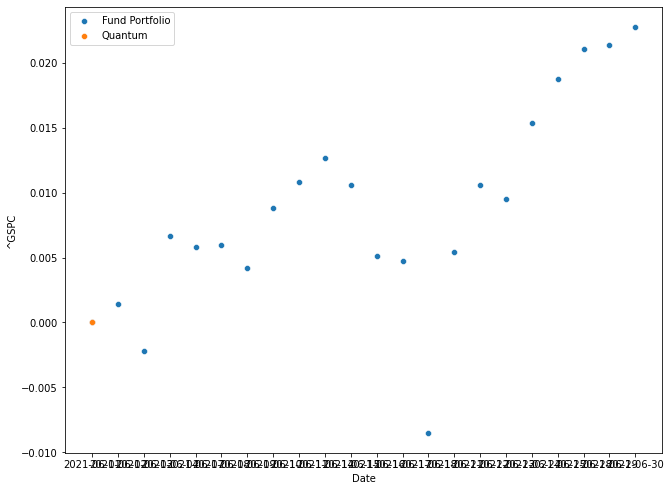


Run completed.

idx: 2021-06-02
new purchase budget: 0.0, initial_budget: 1000000
idx: 2021-06-02
self.position: 103
self.initial_position: 2021-05-25
sum price: 85001.72534179688
sum daily returns: 5.174047626322508
avg daily returns: 0.09581525483394548
covariance_matrix sum: 3.104535090209451
correlation_matrix sum: 16948.55679407505
t_cost True
t_cost: 0.0001
upper bound = budget: 0.0
init_budget: 1000000
lower bound: -3000.0
n_samples: 96
solution_stocks: {'A': 17, 'AAL': 39, 'AAP': 2, 'AAPL': 63, 'ABBV': 5, 'ABC': 6, 'ABT': 8, 'ACGL': 26, 'ACN': 5, 'ADBE': 8, 'ADI': 31, 'ADM': 21, 'ADP': 0, 'ADSK': 14, 'AEE': 17, 'AEP': 84, 'AES': 16, 'AFL': 27, 'AIG': 1, 'AIZ': 4, 'AJG': 6, 'AKAM': 22, 'ALB': 0, 'ALGN': 0, 'ALK': 3, 'ALL': 20, 'ALLE': 13, 'AMAT': 45, 'AMCR': 70, 'AMD': 34, 'AME': 7, 'AMGN': 4, 'AMP': 6, 'AMT': 3, 'AMZN': 27, 'ANET': 15, 'ANSS': 4, 'AON': 4, 'AOS': 10, 'APA': 48, 'APD': 0, 'APH': 83, 'APTV': 0, 'ARE': 21, 'ATO': 4, 'ATVI': 1, 'AVB': 34, 'AVGO': 0, 'AVY': 7, 'AWK

,idx,variance,returns,value,value_norm
0,2021-06-01,24.21,-506.66,9.998904e+05,0.000000
0,2021-06-02,268.69,51.70,1.001747e+06,0.001856


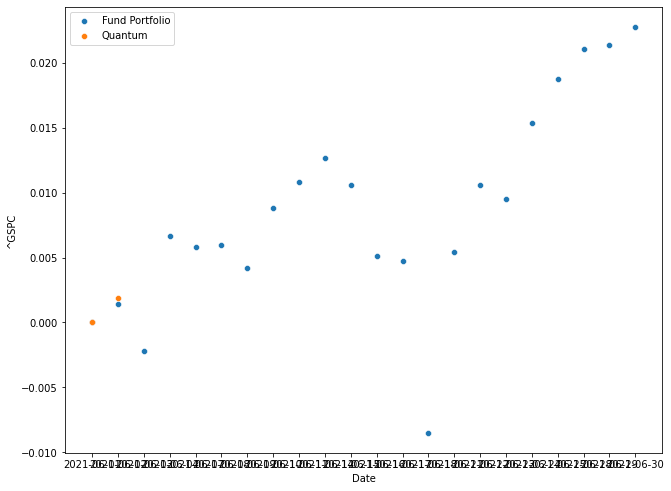


Run completed.

idx: 2021-06-03
new purchase budget: 0.0, initial_budget: 1000000
idx: 2021-06-03
self.position: 104
self.initial_position: 2021-05-26
sum price: 84659.29285907745
sum daily returns: 6.6112072361328
avg daily returns: 0.4372141047967597
covariance_matrix sum: 1.5945813906740585
correlation_matrix sum: 7577.044796243773
t_cost True
t_cost: 0.0001
upper bound = budget: 0.0
init_budget: 1000000
lower bound: -3000.0
n_samples: 79
solution_stocks: {'A': 73, 'AAL': 39, 'AAP': 0, 'AAPL': 0, 'ABBV': 0, 'ABC': 0, 'ABT': 1315, 'ACGL': 27, 'ACN': 0, 'ADBE': 0, 'ADI': 1, 'ADM': 1, 'ADP': 5, 'ADSK': 0, 'AEE': 1, 'AEP': 17, 'AES': 60, 'AFL': 58, 'AIG': 5, 'AIZ': 7, 'AJG': 3, 'AKAM': 0, 'ALB': 0, 'ALGN': 0, 'ALK': 0, 'ALL': 0, 'ALLE': 10, 'AMAT': 31, 'AMCR': 79, 'AMD': 64, 'AME': 0, 'AMGN': 0, 'AMP': 0, 'AMT': 0, 'AMZN': 0, 'ANET': 0, 'ANSS': 0, 'AON': 5, 'AOS': 27, 'APA': 24, 'APD': 24, 'APH': 2, 'APTV': 39, 'ARE': 1, 'ATO': 0, 'ATVI': 0, 'AVB': 1, 'AVGO': 13, 'AVY': 1, 'AWK': 11, '

,idx,variance,returns,value,value_norm
0,2021-06-01,24.21,-506.66,9.998904e+05,0.000000
0,2021-06-02,268.69,51.70,1.001747e+06,0.001856
0,2021-06-03,224.50,957.67,9.995031e+05,-0.000387


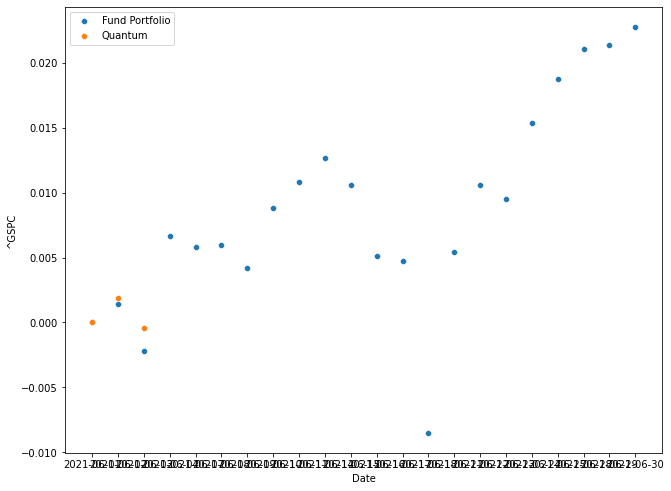


Run completed.

idx: 2021-06-04
new purchase budget: 0.0, initial_budget: 1000000
idx: 2021-06-04
self.position: 105
self.initial_position: 2021-05-27
sum price: 85275.94334030151
sum daily returns: 7.355593444948617
avg daily returns: -0.32391752499089166
covariance_matrix sum: 1.9660372435400326
correlation_matrix sum: 10544.654497940206
t_cost True
t_cost: 0.0001
upper bound = budget: 0.0
init_budget: 1000000
lower bound: -3000.0
n_samples: 94
solution_stocks: {'A': 0, 'AAL': 207, 'AAP': 0, 'AAPL': 26, 'ABBV': 16, 'ABC': 0, 'ABT': 0, 'ACGL': 28, 'ACN': 0, 'ADBE': 0, 'ADI': 0, 'ADM': 0, 'ADP': 0, 'ADSK': 0, 'AEE': 1, 'AEP': 0, 'AES': 26, 'AFL': 7, 'AIG': 72, 'AIZ': 0, 'AJG': 3, 'AKAM': 21, 'ALB': 38, 'ALGN': 0, 'ALK': 0, 'ALL': 3, 'ALLE': 10, 'AMAT': 14, 'AMCR': 358, 'AMD': 90, 'AME': 42, 'AMGN': 22, 'AMP': 41, 'AMT': 0, 'AMZN': 0, 'ANET': 0, 'ANSS': 0, 'AON': 5, 'AOS': 0, 'APA': 111, 'APD': 0, 'APH': 2, 'APTV': 0, 'ARE': 0, 'ATO': 29, 'ATVI': 0, 'AVB': 0, 'AVGO': 0, 'AVY': 2, 'AWK'

,idx,variance,returns,value,value_norm
0,2021-06-01,24.21,-506.66,9.998904e+05,0.000000
0,2021-06-02,268.69,51.70,1.001747e+06,0.001856
0,2021-06-03,224.50,957.67,9.995031e+05,-0.000387
0,2021-06-04,85.03,46.26,1.005378e+06,0.005488


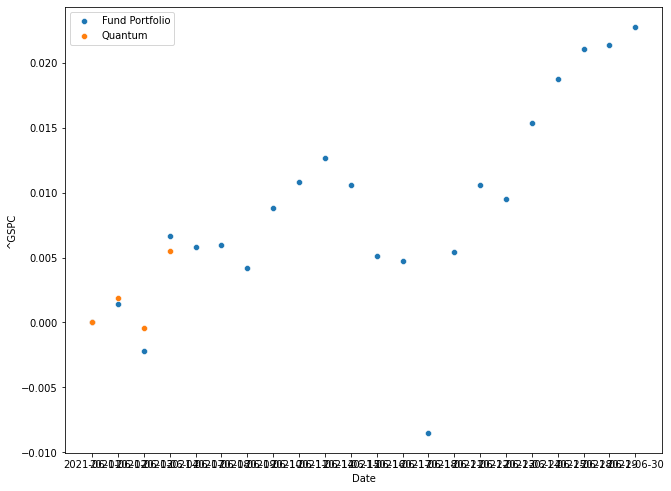


Run completed.

idx: 2021-06-07
new purchase budget: 0.0, initial_budget: 1000000
idx: 2021-06-07
self.position: 106
self.initial_position: 2021-05-28
sum price: 85111.30095863342
sum daily returns: 3.9844560750148212
avg daily returns: 0.6934359313634199
covariance_matrix sum: 2.1571444215638502
correlation_matrix sum: 17195.225858268517
t_cost True
t_cost: 0.0001
upper bound = budget: 0.0
init_budget: 1000000
lower bound: -3000.0
n_samples: 76
solution_stocks: {'A': 65, 'AAL': 47, 'AAP': 0, 'AAPL': 0, 'ABBV': 2, 'ABC': 5, 'ABT': 84, 'ACGL': 44, 'ACN': 0, 'ADBE': 0, 'ADI': 0, 'ADM': 2, 'ADP': 0, 'ADSK': 0, 'AEE': 1, 'AEP': 2, 'AES': 0, 'AFL': 1, 'AIG': 57, 'AIZ': 32, 'AJG': 22, 'AKAM': 0, 'ALB': 0, 'ALGN': 0, 'ALK': 0, 'ALL': 44, 'ALLE': 3, 'AMAT': 0, 'AMCR': 318, 'AMD': 0, 'AME': 25, 'AMGN': 45, 'AMP': 0, 'AMT': 0, 'AMZN': 0, 'ANET': 6, 'ANSS': 0, 'AON': 18, 'AOS': 2, 'APA': 20, 'APD': 30, 'APH': 13, 'APTV': 0, 'ARE': 0, 'ATO': 4, 'ATVI': 0, 'AVB': 17, 'AVGO': 0, 'AVY': 6, 'AWK': 26

,idx,variance,returns,value,value_norm
0,2021-06-01,24.21,-506.66,9.998904e+05,0.000000
0,2021-06-02,268.69,51.70,1.001747e+06,0.001856
0,2021-06-03,224.50,957.67,9.995031e+05,-0.000387
0,2021-06-04,85.03,46.26,1.005378e+06,0.005488
0,2021-06-07,2136.90,5321.84,1.006534e+06,0.006645


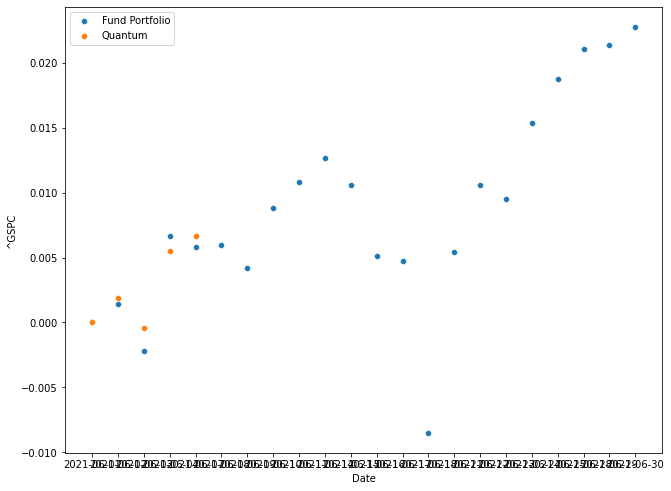


Run completed.

idx: 2021-06-08


/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


new purchase budget: 0.0, initial_budget: 1000000
idx: 2021-06-08
self.position: 107
self.initial_position: 2021-06-01
sum price: 85354.41888237
sum daily returns: 4.256407036478969
avg daily returns: 0.1283249612931272
covariance_matrix sum: 2.1673194860679343
correlation_matrix sum: 16290.876901755571
t_cost True
t_cost: 0.0001
upper bound = budget: 0.0
init_budget: 1000000
lower bound: -3000.0
n_samples: 81
solution_stocks: {'A': 0, 'AAL': 40, 'AAP': 0, 'AAPL': 12, 'ABBV': 5, 'ABC': 10, 'ABT': 122, 'ACGL': 36, 'ACN': 0, 'ADBE': 0, 'ADI': 0, 'ADM': 85, 'ADP': 8, 'ADSK': 0, 'AEE': 16, 'AEP': 23, 'AES': 190, 'AFL': 16, 'AIG': 79, 'AIZ': 9, 'AJG': 18, 'AKAM': 8, 'ALB': 0, 'ALGN': 0, 'ALK': 24, 'ALL': 15, 'ALLE': 1, 'AMAT': 0, 'AMCR': 38, 'AMD': 35, 'AME': 6, 'AMGN': 1, 'AMP': 0, 'AMT': 3, 'AMZN': 3, 'ANET': 17, 'ANSS': 0, 'AON': 9, 'AOS': 4, 'APA': 54, 'APD': 0, 'APH': 35, 'APTV': 0, 'ARE': 4, 'ATO': 43, 'ATVI': 0, 'AVB': 5, 'AVGO': 0, 'AVY': 6, 'AWK': 26, 'AXP': 21, 'AZO': 0, 'BA': 0, 

,idx,variance,returns,value,value_norm
0,2021-06-01,24.21,-506.66,9.998904e+05,0.000000
0,2021-06-02,268.69,51.70,1.001747e+06,0.001856
0,2021-06-03,224.50,957.67,9.995031e+05,-0.000387
0,2021-06-04,85.03,46.26,1.005378e+06,0.005488
0,2021-06-07,2136.90,5321.84,1.006534e+06,0.006645
0,2021-06-08,441.01,718.18,1.009312e+06,0.009422


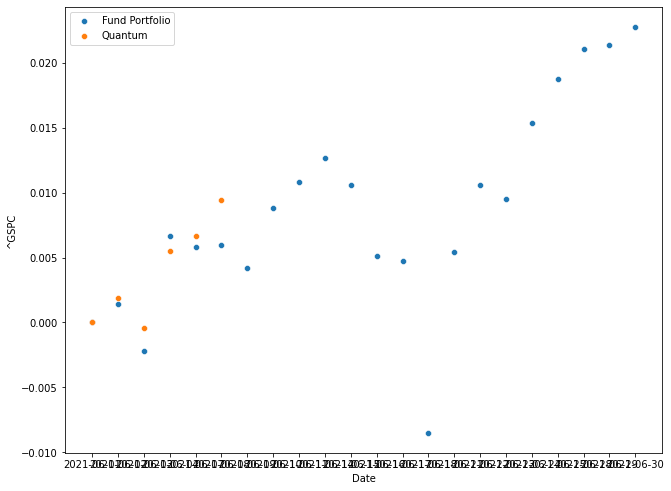


Run completed.

idx: 2021-06-09
new purchase budget: 0.0, initial_budget: 1000000
idx: 2021-06-09
self.position: 108
self.initial_position: 2021-06-02
sum price: 85062.990858078
sum daily returns: 0.30333283866734684
avg daily returns: 0.33674212207945164
covariance_matrix sum: 3.0014658086361807
correlation_matrix sum: 23825.44899888403
t_cost True
t_cost: 0.0001
upper bound = budget: 0.0
init_budget: 1000000
lower bound: -3000.0
n_samples: 81
solution_stocks: {'A': 21, 'AAL': 100, 'AAP': 33, 'AAPL': 0, 'ABBV': 20, 'ABC': 0, 'ABT': 9, 'ACGL': 0, 'ACN': 0, 'ADBE': 0, 'ADI': 0, 'ADM': 0, 'ADP': 13, 'ADSK': 0, 'AEE': 10, 'AEP': 2, 'AES': 8, 'AFL': 0, 'AIG': 2, 'AIZ': 6, 'AJG': 7, 'AKAM': 12, 'ALB': 0, 'ALGN': 0, 'ALK': 0, 'ALL': 0, 'ALLE': 3, 'AMAT': 0, 'AMCR': 529, 'AMD': 0, 'AME': 50, 'AMGN': 20, 'AMP': 0, 'AMT': 0, 'AMZN': 0, 'ANET': 3, 'ANSS': 0, 'AON': 20, 'AOS': 45, 'APA': 36, 'APD': 0, 'APH': 71, 'APTV': 0, 'ARE': 1, 'ATO': 34, 'ATVI': 0, 'AVB': 2, 'AVGO': 0, 'AVY': 6, 'AWK': 21,

,idx,variance,returns,value,value_norm
0,2021-06-01,24.21,-506.66,9.998904e+05,0.000000
0,2021-06-02,268.69,51.70,1.001747e+06,0.001856
0,2021-06-03,224.50,957.67,9.995031e+05,-0.000387
0,2021-06-04,85.03,46.26,1.005378e+06,0.005488
0,2021-06-07,2136.90,5321.84,1.006534e+06,0.006645
0,2021-06-08,441.01,718.18,1.009312e+06,0.009422
0,2021-06-09,6175.74,872.69,1.004784e+06,0.004894


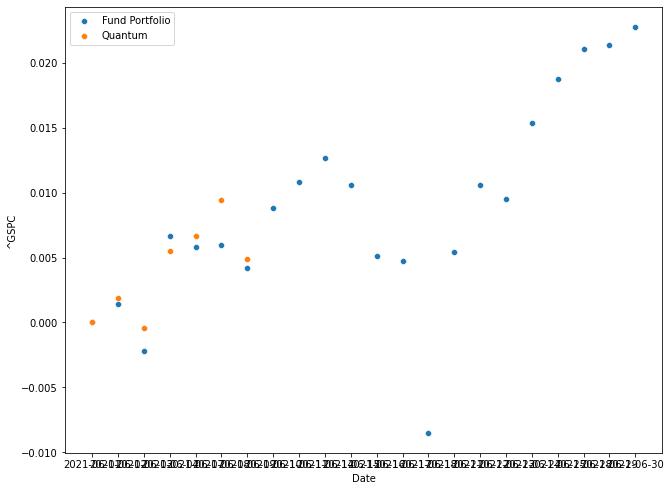


Run completed.

idx: 2021-06-10
new purchase budget: 0.0, initial_budget: 1000000
idx: 2021-06-10
self.position: 109
self.initial_position: 2021-06-03
sum price: 85266.81881809235
sum daily returns: 0.6640055792087519
avg daily returns: -0.05940810036116784
covariance_matrix sum: 3.0931501721800077
correlation_matrix sum: 24776.55517271915
t_cost True
t_cost: 0.0001
upper bound = budget: 0.0
init_budget: 1000000
lower bound: -3000.0
n_samples: 75
solution_stocks: {'A': 0, 'AAL': 34, 'AAP': 0, 'AAPL': 0, 'ABBV': 20, 'ABC': 0, 'ABT': 89, 'ACGL': 0, 'ACN': 0, 'ADBE': 0, 'ADI': 0, 'ADM': 23, 'ADP': 0, 'ADSK': 0, 'AEE': 178, 'AEP': 24, 'AES': 22, 'AFL': 0, 'AIG': 1, 'AIZ': 4, 'AJG': 18, 'AKAM': 0, 'ALB': 0, 'ALGN': 0, 'ALK': 8, 'ALL': 33, 'ALLE': 0, 'AMAT': 0, 'AMCR': 34, 'AMD': 0, 'AME': 4, 'AMGN': 17, 'AMP': 0, 'AMT': 0, 'AMZN': 0, 'ANET': 55, 'ANSS': 0, 'AON': 30, 'AOS': 7, 'APA': 57, 'APD': 0, 'APH': 36, 'APTV': 0, 'ARE': 0, 'ATO': 41, 'ATVI': 0, 'AVB': 0, 'AVGO': 0, 'AVY': 28, 'AWK': 

,idx,variance,returns,value,value_norm
0,2021-06-01,24.21,-506.66,9.998904e+05,0.000000
0,2021-06-02,268.69,51.70,1.001747e+06,0.001856
0,2021-06-03,224.50,957.67,9.995031e+05,-0.000387
0,2021-06-04,85.03,46.26,1.005378e+06,0.005488
0,2021-06-07,2136.90,5321.84,1.006534e+06,0.006645
0,2021-06-08,441.01,718.18,1.009312e+06,0.009422
0,2021-06-09,6175.74,872.69,1.004784e+06,0.004894
0,2021-06-10,9917.57,372.36,1.006765e+06,0.006875


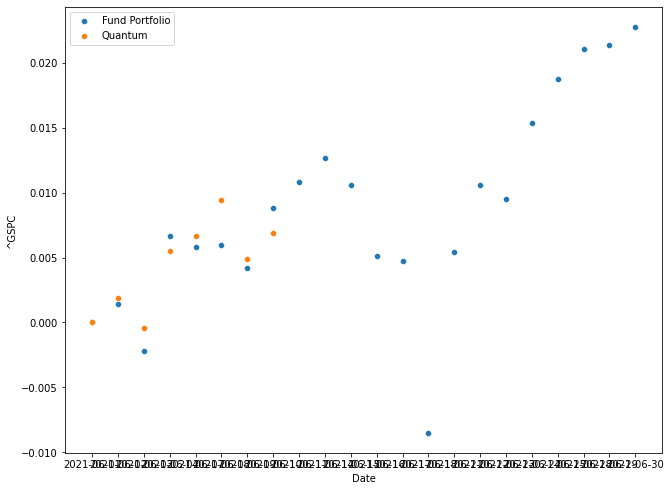


Run completed.

idx: 2021-06-11
new purchase budget: 0.0, initial_budget: 1000000
idx: 2021-06-11
self.position: 110
self.initial_position: 2021-06-04
sum price: 85585.98109912872
sum daily returns: 3.3131259441749794
avg daily returns: -0.13345020935019902
covariance_matrix sum: 3.16434637412156
correlation_matrix sum: 30001.816362093417
t_cost True
t_cost: 0.0001
upper bound = budget: 0.0
init_budget: 1000000
lower bound: -3000.0
n_samples: 88
solution_stocks: {'A': 7, 'AAL': 245, 'AAP': 0, 'AAPL': 35, 'ABBV': 84, 'ABC': 0, 'ABT': 22, 'ACGL': 0, 'ACN': 0, 'ADBE': 0, 'ADI': 1, 'ADM': 23, 'ADP': 0, 'ADSK': 0, 'AEE': 33, 'AEP': 81, 'AES': 55, 'AFL': 17, 'AIG': 2, 'AIZ': 31, 'AJG': 16, 'AKAM': 33, 'ALB': 9, 'ALGN': 0, 'ALK': 31, 'ALL': 4, 'ALLE': 0, 'AMAT': 0, 'AMCR': 32, 'AMD': 0, 'AME': 0, 'AMGN': 21, 'AMP': 0, 'AMT': 0, 'AMZN': 12, 'ANET': 0, 'ANSS': 0, 'AON': 30, 'AOS': 34, 'APA': 79, 'APD': 0, 'APH': 59, 'APTV': 18, 'ARE': 0, 'ATO': 30, 'ATVI': 0, 'AVB': 0, 'AVGO': 0, 'AVY': 3, 'AW

,idx,variance,returns,value,value_norm
0,2021-06-01,24.21,-506.66,9.998904e+05,0.000000
0,2021-06-02,268.69,51.70,1.001747e+06,0.001856
0,2021-06-03,224.50,957.67,9.995031e+05,-0.000387
0,2021-06-04,85.03,46.26,1.005378e+06,0.005488
0,2021-06-07,2136.90,5321.84,1.006534e+06,0.006645
0,2021-06-08,441.01,718.18,1.009312e+06,0.009422
0,2021-06-09,6175.74,872.69,1.004784e+06,0.004894
0,2021-06-10,9917.57,372.36,1.006765e+06,0.006875
0,2021-06-11,666.86,-877.82,1.006680e+06,0.006790


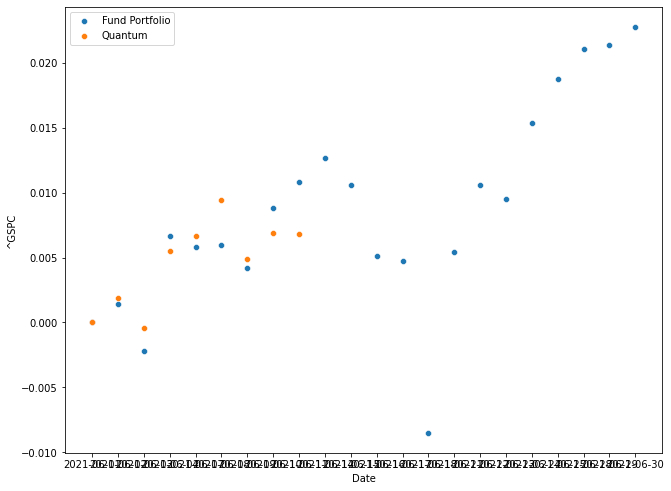


Run completed.

idx: 2021-06-14
new purchase budget: 0.0, initial_budget: 1000000
idx: 2021-06-14
self.position: 111
self.initial_position: 2021-06-07
sum price: 85598.31927394867
sum daily returns: -1.3152541765023318
avg daily returns: 0.06407913222158157
covariance_matrix sum: 2.6035019530671444
correlation_matrix sum: 25286.49709036214
t_cost True
t_cost: 0.0001
upper bound = budget: 0.0
init_budget: 1000000
lower bound: -3000.0
n_samples: 84
solution_stocks: {'A': 10, 'AAL': 17, 'AAP': 0, 'AAPL': 35, 'ABBV': 0, 'ABC': 0, 'ABT': 37, 'ACGL': 24, 'ACN': 16, 'ADBE': 0, 'ADI': 18, 'ADM': 59, 'ADP': 0, 'ADSK': 0, 'AEE': 5, 'AEP': 18, 'AES': 4, 'AFL': 36, 'AIG': 38, 'AIZ': 0, 'AJG': 13, 'AKAM': 0, 'ALB': 92, 'ALGN': 0, 'ALK': 5, 'ALL': 25, 'ALLE': 18, 'AMAT': 0, 'AMCR': 56, 'AMD': 0, 'AME': 0, 'AMGN': 0, 'AMP': 0, 'AMT': 0, 'AMZN': 0, 'ANET': 0, 'ANSS': 0, 'AON': 7, 'AOS': 24, 'APA': 299, 'APD': 0, 'APH': 87, 'APTV': 33, 'ARE': 0, 'ATO': 4, 'ATVI': 39, 'AVB': 0, 'AVGO': 39, 'AVY': 0, 'A

,idx,variance,returns,value,value_norm
0,2021-06-01,24.21,-506.66,9.998904e+05,0.000000
0,2021-06-02,268.69,51.70,1.001747e+06,0.001856
0,2021-06-03,224.50,957.67,9.995031e+05,-0.000387
0,2021-06-04,85.03,46.26,1.005378e+06,0.005488
0,2021-06-07,2136.90,5321.84,1.006534e+06,0.006645
0,2021-06-08,441.01,718.18,1.009312e+06,0.009422
0,2021-06-09,6175.74,872.69,1.004784e+06,0.004894
0,2021-06-10,9917.57,372.36,1.006765e+06,0.006875
0,2021-06-11,666.86,-877.82,1.006680e+06,0.006790
0,2021-06-14,901.90,569.64,1.003845e+06,0.003955


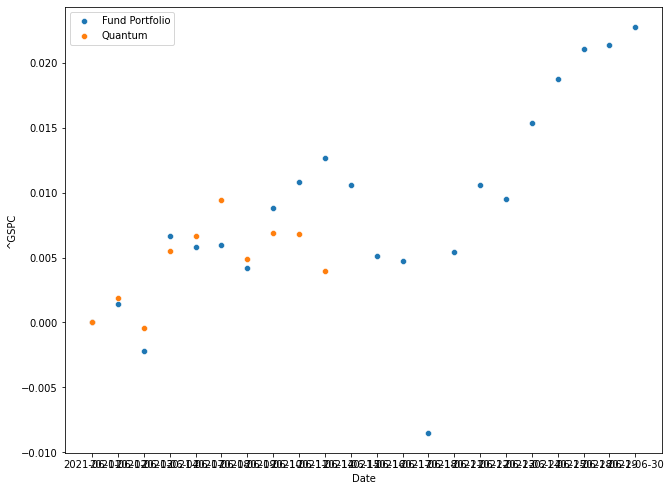


Run completed.

idx: 2021-06-15
new purchase budget: 0.0, initial_budget: 1000000
idx: 2021-06-15
self.position: 112
self.initial_position: 2021-06-08
sum price: 85578.33727169037
sum daily returns: -0.37983780325259153
avg daily returns: -0.0863281029993952
covariance_matrix sum: 2.5012340861876052
correlation_matrix sum: 19824.83329014394
t_cost True
t_cost: 0.0001
upper bound = budget: 0.0
init_budget: 1000000
lower bound: -3000.0
n_samples: 81
solution_stocks: {'A': 5, 'AAL': 121, 'AAP': 7, 'AAPL': 3, 'ABBV': 0, 'ABC': 0, 'ABT': 15, 'ACGL': 0, 'ACN': 5, 'ADBE': 0, 'ADI': 6, 'ADM': 2, 'ADP': 0, 'ADSK': 0, 'AEE': 2, 'AEP': 226, 'AES': 133, 'AFL': 1, 'AIG': 8, 'AIZ': 11, 'AJG': 26, 'AKAM': 0, 'ALB': 0, 'ALGN': 0, 'ALK': 7, 'ALL': 10, 'ALLE': 45, 'AMAT': 9, 'AMCR': 415, 'AMD': 6, 'AME': 34, 'AMGN': 0, 'AMP': 20, 'AMT': 5, 'AMZN': 0, 'ANET': 1, 'ANSS': 0, 'AON': 16, 'AOS': 45, 'APA': 23, 'APD': 2, 'APH': 49, 'APTV': 5, 'ARE': 0, 'ATO': 28, 'ATVI': 44, 'AVB': 0, 'AVGO': 1, 'AVY': 0, 'AW

,idx,variance,returns,value,value_norm
0,2021-06-01,24.21,-506.66,9.998904e+05,0.000000
0,2021-06-02,268.69,51.70,1.001747e+06,0.001856
0,2021-06-03,224.50,957.67,9.995031e+05,-0.000387
0,2021-06-04,85.03,46.26,1.005378e+06,0.005488
0,2021-06-07,2136.90,5321.84,1.006534e+06,0.006645
0,2021-06-08,441.01,718.18,1.009312e+06,0.009422
0,2021-06-09,6175.74,872.69,1.004784e+06,0.004894
0,2021-06-10,9917.57,372.36,1.006765e+06,0.006875
0,2021-06-11,666.86,-877.82,1.006680e+06,0.006790
0,2021-06-14,901.90,569.64,1.003845e+06,0.003955


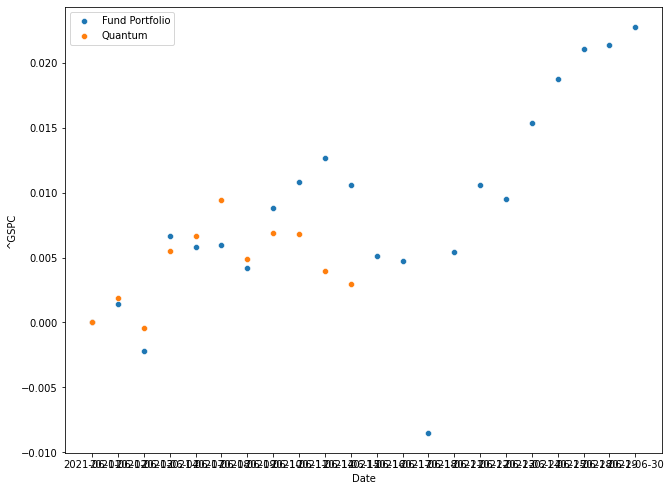


Run completed.

idx: 2021-06-16
new purchase budget: 0.0, initial_budget: 1000000
idx: 2021-06-16
self.position: 113
self.initial_position: 2021-06-09
sum price: 85050.04096126556
sum daily returns: -4.522985085018768
avg daily returns: -0.1807783338787038
covariance_matrix sum: 3.738797675148933
correlation_matrix sum: 35927.86681970685
t_cost True
t_cost: 0.0001
upper bound = budget: 0.0
init_budget: 1000000
lower bound: -3000.0
n_samples: 83
solution_stocks: {'A': 0, 'AAL': 76, 'AAP': 0, 'AAPL': 43, 'ABBV': 42, 'ABC': 15, 'ABT': 10, 'ACGL': 52, 'ACN': 0, 'ADBE': 0, 'ADI': 0, 'ADM': 16, 'ADP': 0, 'ADSK': 0, 'AEE': 41, 'AEP': 9, 'AES': 144, 'AFL': 54, 'AIG': 1, 'AIZ': 0, 'AJG': 8, 'AKAM': 0, 'ALB': 54, 'ALGN': 0, 'ALK': 73, 'ALL': 18, 'ALLE': 25, 'AMAT': 38, 'AMCR': 143, 'AMD': 0, 'AME': 29, 'AMGN': 0, 'AMP': 0, 'AMT': 3, 'AMZN': 42, 'ANET': 16, 'ANSS': 0, 'AON': 0, 'AOS': 75, 'APA': 95, 'APD': 0, 'APH': 57, 'APTV': 52, 'ARE': 60, 'ATO': 28, 'ATVI': 44, 'AVB': 0, 'AVGO': 4, 'AVY': 0,

,idx,variance,returns,value,value_norm
0,2021-06-01,24.21,-506.66,9.998904e+05,0.000000
0,2021-06-02,268.69,51.70,1.001747e+06,0.001856
0,2021-06-03,224.50,957.67,9.995031e+05,-0.000387
0,2021-06-04,85.03,46.26,1.005378e+06,0.005488
0,2021-06-07,2136.90,5321.84,1.006534e+06,0.006645
0,2021-06-08,441.01,718.18,1.009312e+06,0.009422
0,2021-06-09,6175.74,872.69,1.004784e+06,0.004894
0,2021-06-10,9917.57,372.36,1.006765e+06,0.006875
0,2021-06-11,666.86,-877.82,1.006680e+06,0.006790
0,2021-06-14,901.90,569.64,1.003845e+06,0.003955


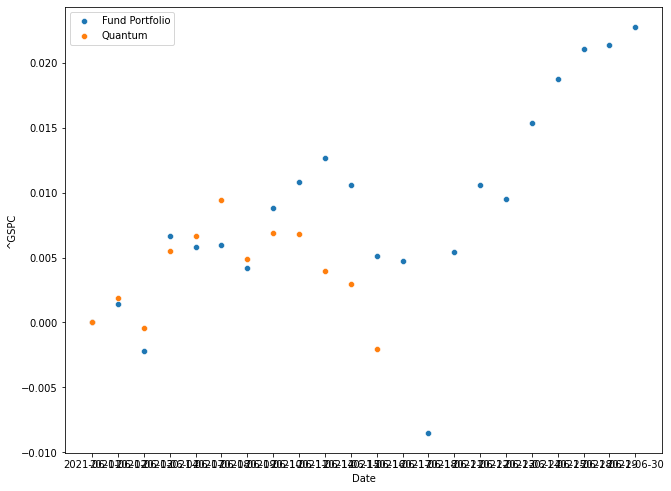


Run completed.

idx: 2021-06-17
new purchase budget: 0.0, initial_budget: 1000000
idx: 2021-06-17
self.position: 114
self.initial_position: 2021-06-10
sum price: 84958.07829475403
sum daily returns: -7.106016611661824
avg daily returns: 0.5143204269046704
covariance_matrix sum: 6.266574241554404
correlation_matrix sum: 37182.25171139822
t_cost True
t_cost: 0.0001
upper bound = budget: 0.0
init_budget: 1000000
lower bound: -3000.0
n_samples: 82
solution_stocks: {'A': 62, 'AAL': 29, 'AAP': 7, 'AAPL': 28, 'ABBV': 1, 'ABC': 0, 'ABT': 32, 'ACGL': 34, 'ACN': 1, 'ADBE': 0, 'ADI': 8, 'ADM': 110, 'ADP': 1, 'ADSK': 4, 'AEE': 48, 'AEP': 2, 'AES': 58, 'AFL': 35, 'AIG': 5, 'AIZ': 1, 'AJG': 10, 'AKAM': 14, 'ALB': 53, 'ALGN': 0, 'ALK': 36, 'ALL': 16, 'ALLE': 24, 'AMAT': 2, 'AMCR': 41, 'AMD': 28, 'AME': 11, 'AMGN': 1, 'AMP': 0, 'AMT': 13, 'AMZN': 42, 'ANET': 0, 'ANSS': 0, 'AON': 0, 'AOS': 21, 'APA': 11, 'APD': 5, 'APH': 1, 'APTV': 13, 'ARE': 0, 'ATO': 0, 'ATVI': 12, 'AVB': 1, 'AVGO': 15, 'AVY': 0, 'A

,idx,variance,returns,value,value_norm
0,2021-06-01,24.21,-506.66,9.998904e+05,0.000000
0,2021-06-02,268.69,51.70,1.001747e+06,0.001856
0,2021-06-03,224.50,957.67,9.995031e+05,-0.000387
0,2021-06-04,85.03,46.26,1.005378e+06,0.005488
0,2021-06-07,2136.90,5321.84,1.006534e+06,0.006645
0,2021-06-08,441.01,718.18,1.009312e+06,0.009422
0,2021-06-09,6175.74,872.69,1.004784e+06,0.004894
0,2021-06-10,9917.57,372.36,1.006765e+06,0.006875
0,2021-06-11,666.86,-877.82,1.006680e+06,0.006790
0,2021-06-14,901.90,569.64,1.003845e+06,0.003955


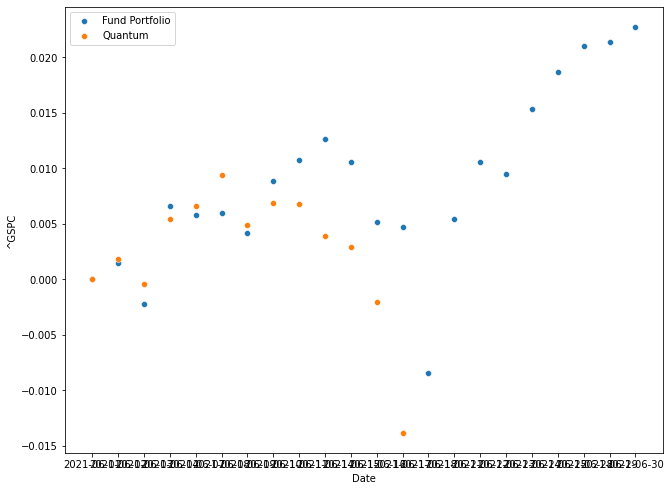


Run completed.

idx: 2021-06-18


/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


new purchase budget: 0.0, initial_budget: 1000000
idx: 2021-06-18
self.position: 115
self.initial_position: 2021-06-11
sum price: 84001.41749572754
sum daily returns: -16.288349528770116
avg daily returns: -0.1600224499145193
covariance_matrix sum: 12.676498839198523
correlation_matrix sum: 61439.77491171129
t_cost True
t_cost: 0.0001
upper bound = budget: 0.0
init_budget: 1000000
lower bound: -3000.0


BufferError: ignored

In [9]:
print('initial df')
display(df.head())

# if not init_holdings_path: 
#     init_holdings_df, budget = generate_initial_state(df, n_iter, r_cross, r_mut, n_pop, budget)
#     init_holdings_df.to_pickle(save_path+'init_holdings.pkl')
# else:
#     init_holdings_df = pd.read_pickle(init_holdings_path)
#     prices = df.loc[dates[0], :].values.tolist()
#     #print('init holdings df')
#     #display(init_holdings_df.head())
#     #print(f'prices: {prices}')
#     pop = init_holdings_df['b'].values.tolist()
#     #print(f'pop: {pop}')
#     budget = sum([d1 * d2 for d1, d2 in zip(prices, pop)])
#     print(f'GA budget: {budget}')

# init_holdings = {}
# for idx, row in init_holdings_df.iterrows():
#     init_holdings.update({row['a']: row['b']})
init_holdings = {s:0 for s in stocks}

#print(f'init_holdings: {init_holdings}')
#print(f'new budget: {budget}')
  
# checking if the directory demo_folder 
# exist or not.
if not os.path.exists(save_path+label):
    os.makedirs(save_path+label)

my_portfolio = MultiPeriod(data=df,
                        baseline=df_baseline,
                        budget=budget,
                        sampler_args=sampler_args,
                        dates=dates,
                        file_path=file_path,
                        model_type=model_type,
                        alpha=alpha,
                        verbose=verbose,
                        t_cost=t_cost,
                        label=label,
                        init_holdings=init_holdings,
                        save_path=save_path+label+'/'
                        )

my_portfolio.run(min_return=min_return, max_risk=max_risk, num=num)